In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
from PIL import Image

In [2]:
# Set random seed
torch.manual_seed(42)
np.random.seed(42)

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Set input path and parameters
input_dir = '/kaggle/input/handwritten-digit-classification/database'
input_size = 224
batch_size = 32

In [5]:
# Define transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Load dataset
dataset = datasets.ImageFolder(root=input_dir, transform=data_transforms['train'])

# Train/Val split
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Apply transforms again
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Loaders and classes
dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = dataset.classes
print("Class names:", class_names)


Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [6]:
# Load MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# Freeze base layers
for param in model.features.parameters():
    param.requires_grad = False

# Replace final classifier
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 10)  # 10 digit classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 164MB/s]


In [7]:
def train_model(model, criterion, optimizer, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

            print(f"{phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

            # Save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f"\nBest Validation Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [8]:
num_epochs = 20
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, criterion, optimizer, num_epochs)



Epoch 1/20
------------------------------
train Loss: 0.6341, Acc: 0.8189
val Loss: 0.3295, Acc: 0.8989

Epoch 2/20
------------------------------
train Loss: 0.3426, Acc: 0.8922
val Loss: 0.2425, Acc: 0.9277

Epoch 3/20
------------------------------
train Loss: 0.2997, Acc: 0.9035
val Loss: 0.2229, Acc: 0.9309

Epoch 4/20
------------------------------
train Loss: 0.2831, Acc: 0.9076
val Loss: 0.1947, Acc: 0.9372

Epoch 5/20
------------------------------
train Loss: 0.2705, Acc: 0.9090
val Loss: 0.2042, Acc: 0.9345

Epoch 6/20
------------------------------
train Loss: 0.2608, Acc: 0.9119
val Loss: 0.1921, Acc: 0.9389

Epoch 7/20
------------------------------
train Loss: 0.2605, Acc: 0.9114
val Loss: 0.1740, Acc: 0.9437

Epoch 8/20
------------------------------
train Loss: 0.2499, Acc: 0.9159
val Loss: 0.1694, Acc: 0.9445

Epoch 9/20
------------------------------
train Loss: 0.2427, Acc: 0.9179
val Loss: 0.1842, Acc: 0.9412

Epoch 10/20
------------------------------
train Loss:

In [10]:
# Convert tensor accuracy values to floats
train_accuracies = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in train_accuracies]
val_accuracies = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in val_accuracies]


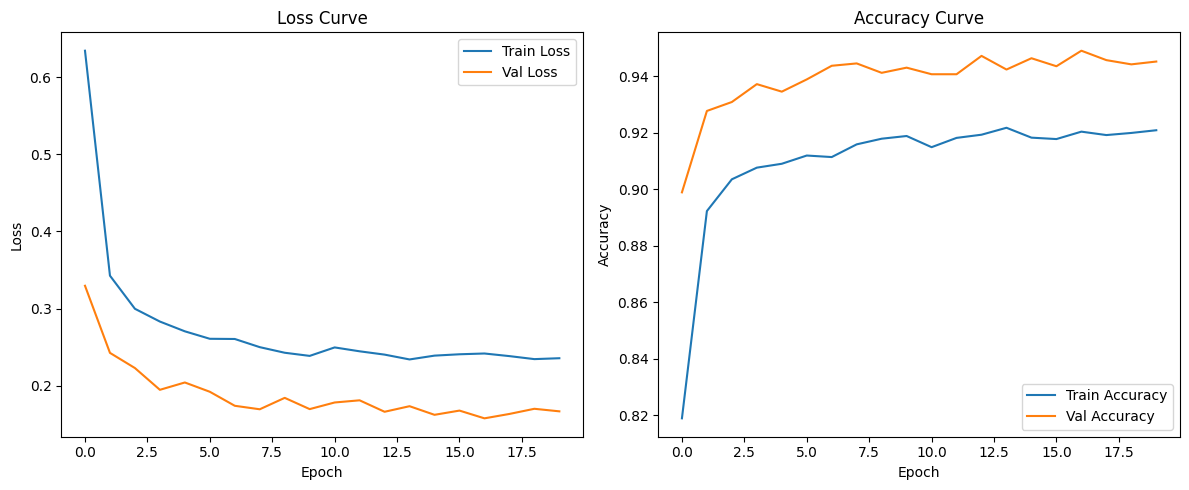

In [11]:
# Plot loss and accuracy
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


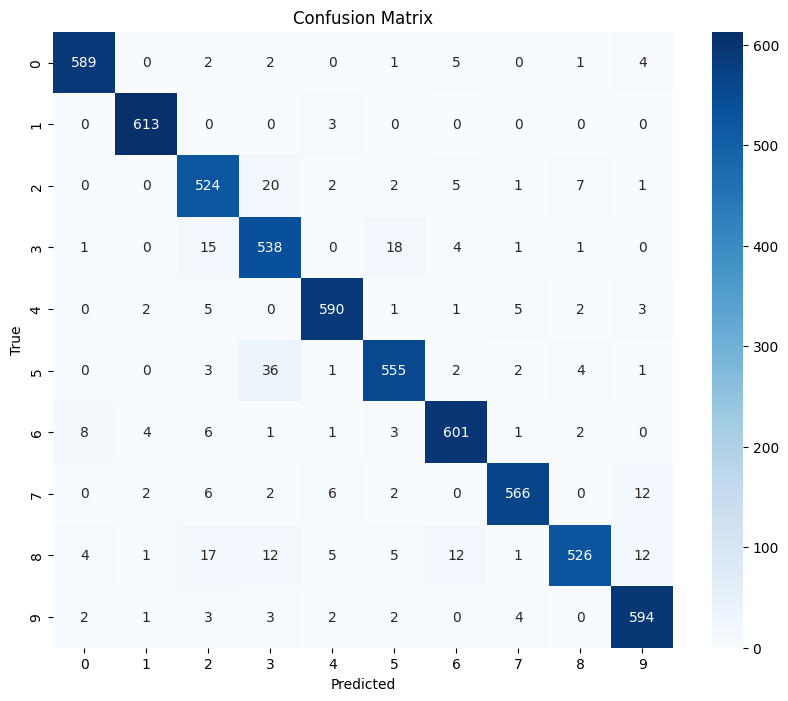

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       604
           1       0.98      1.00      0.99       616
           2       0.90      0.93      0.92       562
           3       0.88      0.93      0.90       578
           4       0.97      0.97      0.97       609
           5       0.94      0.92      0.93       604
           6       0.95      0.96      0.96       627
           7       0.97      0.95      0.96       596
           8       0.97      0.88      0.92       595
           9       0.95      0.97      0.96       611

    accuracy                           0.95      6002
   macro avg       0.95      0.95      0.95      6002
weighted avg       0.95      0.95      0.95      6002

Precision: 0.9491
Recall: 0.9486
F1 Score: 0.9485


In [13]:
# Evaluation
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names))
print(f"Precision: {precision_score(all_labels, all_preds, average='macro'):.4f}")
print(f"Recall: {recall_score(all_labels, all_preds, average='macro'):.4f}")
print(f"F1 Score: {f1_score(all_labels, all_preds, average='macro'):.4f}")


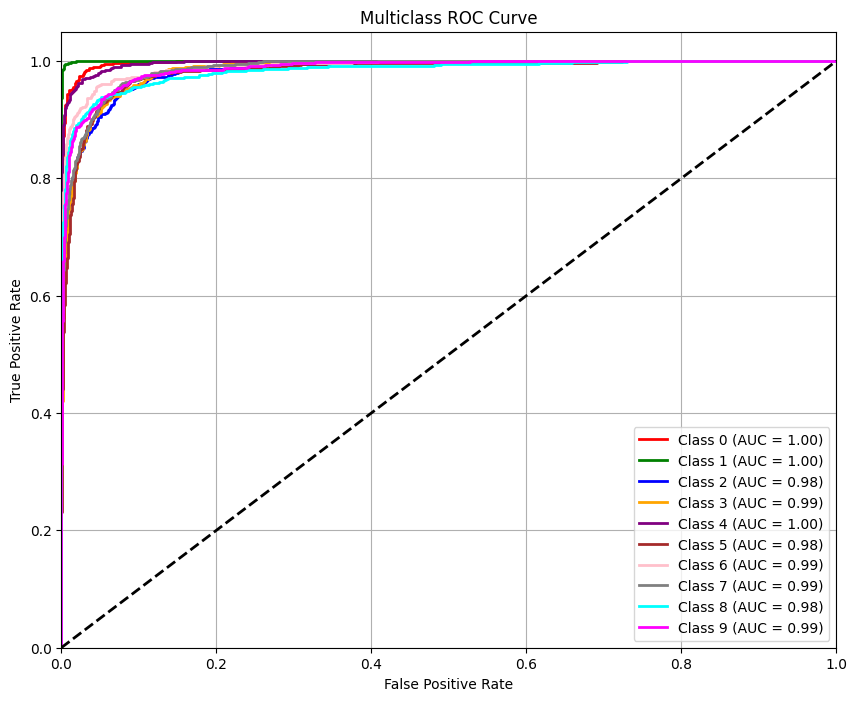

In [15]:
# Binarize the labels for ROC
n_classes = len(class_names)
y_true = label_binarize(all_labels, classes=list(range(n_classes)))

# Collect model prediction probabilities
y_score = []

model.eval()
with torch.no_grad():
    for inputs, _ in dataloaders['val']:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_score.extend(outputs.cpu().numpy())

y_score = np.array(y_score)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("ROC Curve.png", dpi=300, bbox_inches='tight')
plt.show()


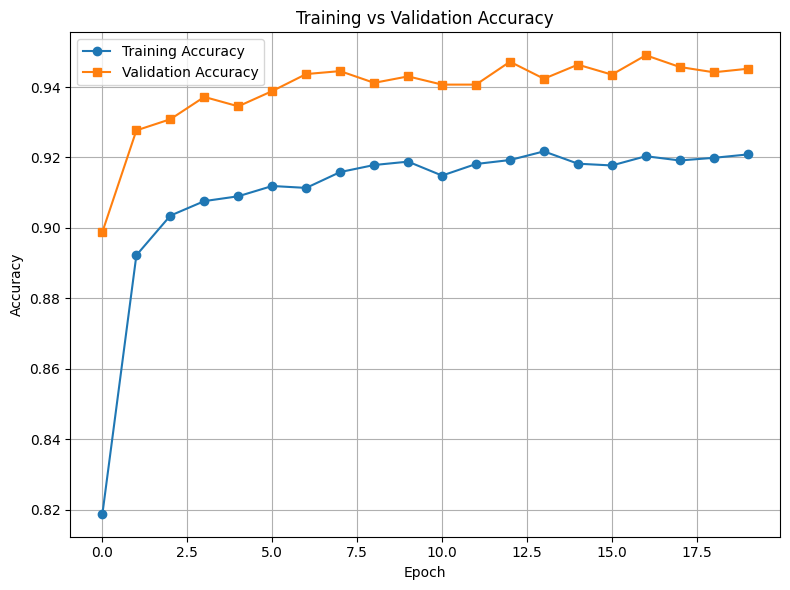

In [25]:
import matplotlib.pyplot as plt
import torch

# Ensure values are floats (not CUDA tensors)
train_accuracies = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in train_accuracies]
val_accuracies = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in val_accuracies]

# Plotting accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Training Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='s')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Training and Validation Accuracy.png", dpi=300, bbox_inches='tight')
plt.show()

In [22]:
import torch.nn.functional as F

# Predict a single image from path
def predict_image(image_path, model):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = data_transforms['val'](image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        probs = F.softmax(output, dim=1)
        confidence, pred = torch.max(probs, 1)

    predicted_label = class_names[pred.item()]
    score = confidence.item() * 100  # Convert to percentage

    return predicted_label, score

# Example usage
test_image_path = '/kaggle/input/handwritten-digit-classification/database/9/train_39_00000.png'  # Replace with your own
predicted_class, confidence = predict_image(test_image_path, model)
print(f"Predicted Class: {predicted_class} (Confidence: {confidence:.2f}%)")



Predicted Class: 9 (Confidence: 98.39%)
